- Change min-risk from 0.001 to 1

- Write fold-opt subsection.

- 

5. For group, report group-wise performance (MSE and Decision Solution&Objective)
     - Closed-Form Done
     - <b>2-Stage Done</b>

6. <b>For Fold-OPT Change PGD closed-form to solver.</b>

8. Verify Individual and Group Regret Performance Done

In [1]:
from src.utils.myOptimization import (
     AlphaFairnesstorch,
    solveIndProblem, solve_closed_form, solve_coupled_group_alpha, compute_coupled_group_obj
)
from src.utils.myPrediction import generate_random_features, customPredictionModel
from src.utils.plots import visLearningCurve
from src.fairness.cal_fair_penalty import atkinson_loss, mean_abs_dev, compute_group_accuracy_parity

from src.utils.myOptimization import AlphaFairness, AlphaFairnesstorch, solve_coupled_group_grad, compute_gradient_closed_form
from src.utils.myOptimization import compute_group_gradient_analytical
# ------------------------------------------------------------------
import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
from torch.autograd import Function
import pandas as pd

from src.utils.features import get_all_features
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")
# ------------------------------------------------------------------


## Define Alpha & Q

In [2]:
# Save to json
import json
params = {
    "n_sample": 5000 ,
    "alpha": 2,
    "Q": 1000,
    "epochs": 50,
    "lambdas": 1.0,
    "lr": 0.01
}

# with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_CF.json", "w") as f:
#     json.dump(params, f, indent=4)

# import json

# with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_CF.json", "r") as f:
#     params = json.load(f)

n_sample = params["n_sample"]
alpha    = params["alpha"]
Q        = params["n_sample"]//2
epochs   = params["epochs"]
lambdas  = params["lambdas"]
lr       = params["lr"]
print(Q)


2500


In [3]:
# df = pd.read_csv('/Users/dennis/Downloads/2024-fall/research/Fairness-Decision-Focused-Loss/Organized-FDFL/src/data/data.csv')
df = pd.read_csv('E:\\myREPO\\Fairness-Decision-Focused-Loss\\Organized-FDFL\\src\\data\\data.csv')
df = df.sample(n=n_sample,random_state=42)

# Normalized cost to 0.1-10 range
cost = np.array(df['cost_t_capped'].values) * 10
cost = np.maximum(cost, 1)

# All features, standardized
features = df[get_all_features(df)].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# True benefit, predictor label normalzied to 1-100 range
benefit = np.array(df['benefit'].values) * 100
benefit = np.maximum(benefit, 1) 
benefit = benefit + 1

# Group labels, 0 is White (Majority), 1 is Black
race = np.array(df['race'].values)

gainF = np.ones_like(benefit)

## Prediction Model

In [4]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x).squeeze(-1)

## JVP calculation (test)

In [5]:
# def solve_coupled_group_jvp(b, c, group_idx, Q, alpha, beta, v):
#     """
#     Computes the vector-Jacobian product v @ J for the coupled group-alpha problem
#     without explicitly forming the full Jacobian matrix J.
#     Complexity: O(n) for each element of the output, avoiding O(n^2).
#     """
#     # Ensure inputs are NumPy arrays
#     b, c, group_idx, v = map(np.asarray, [b, c, group_idx, v])
#     n = len(b)
#     final_grad = np.zeros(n)

#     # --- 1. Forward Pass: Pre-compute terms from the solver ---
#     # This part is identical to the start of the original _grad function
#     if beta > 1:
#         gamma = beta - 2 + alpha - alpha * beta
#         psi_s_exp_factor = (2 - alpha) / gamma
#     else: # beta < 1
#         gamma = beta + alpha - alpha * beta
#         psi_s_exp_factor = -alpha / gamma

#     d_star = solve_coupled_group_alpha(b, c, group_idx, Q, alpha, beta)
#     unique_groups = np.unique(group_idx)
#     S, H, Psi = {}, {}, {}
#     for k in unique_groups:
#         mask = (group_idx == k)
#         G_k, b_k, c_k = np.sum(mask), b[mask], c[mask]
#         S[k] = np.sum((c_k**(-(1-beta)/beta)) * (b_k**((1-beta)/beta)))
#         H[k] = np.sum((c_k**((beta-1)/beta)) * (b_k**((1-beta)/beta)))
#         const_factor = (beta - 1) if beta > 1 else (1 - beta)
#         if beta > 1:
#             Psi[k] = (S[k]**psi_s_exp_factor) * (const_factor**((alpha-2)/gamma))
#         else:
#             Psi[k] = (G_k**((alpha-1)/gamma)) * (S[k]**psi_s_exp_factor) * (const_factor**(alpha/gamma))
#     Xi = np.sum([H[k] * Psi[k] for k in unique_groups])
#     phi_all = (c**(-1/beta)) * (b**((1-beta)/beta))

#     # --- 2. Compute the scalar term `Σᵢ vᵢ * dᵢ*` ---
#     v_dot_d_star = np.dot(v, d_star)

#     # --- 3. Backward Pass: Loop through each prediction `b_j` to get the j-th grad component ---
#     for j in range(n):
#         m = group_idx[j] # Group of the variable b_j

#         # --- Calculate `∂Ξ/∂bⱼ` (same as before) ---
#         dS_m_db_j = ((1-beta)/beta) * (c[j]**(-(1-beta)/beta)) * (b[j]**((1-2*beta)/beta))
#         dH_m_db_j = ((1-beta)/beta) * (c[j]**((beta-1)/beta)) * (b[j]**((1-2*beta)/beta))
#         dPsi_m_db_j = (psi_s_exp_factor / S[m]) * Psi[m] * dS_m_db_j
#         dXi_db_j = dH_m_db_j * Psi[m] + H[m] * dPsi_m_db_j

#         # --- Calculate the JVP-specific term `Σᵢ vᵢ * (∂Nᵢ/∂bⱼ)` ---
#         # ∂Nᵢ/∂bⱼ = Q * ( (∂Ψₖ/∂bⱼ) * φᵢ + Ψₖ * (∂φᵢ/∂bⱼ) )
#         # We need to sum vᵢ * (∂Nᵢ/∂bⱼ) over all i
#         sum_v_dN_db_j = 0
#         dphi_j_db_j = ((1-beta)/beta) * (c[j]**(-1/beta)) * (b[j]**((1-2*beta)/beta))

#         # The derivative ∂Ψₖ/∂bⱼ is only non-zero if k == m
#         # The derivative ∂φᵢ/∂bⱼ is only non-zero if i == j
#         # This makes the sum sparse and efficient to compute
#         sum_v_dN_db_j += Q * dPsi_m_db_j * np.dot(v[group_idx == m], phi_all[group_idx == m])
#         sum_v_dN_db_j += Q * Psi[m] * v[j] * dphi_j_db_j

#         # --- 4. Assemble the final gradient component ---
#         final_grad[j] = (1/Xi) * sum_v_dN_db_j - (dXi_db_j / Xi) * v_dot_d_star

#     return final_grad

## Dataloader

In [6]:
from torch.utils.data import Dataset

def to_numpy_1d(x):
    """Return a 1-D NumPy array; error if the length is not > 1."""
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    x = np.asarray(x).reshape(-1)
    assert x.ndim == 1, f"expected 1-D, got shape {x.shape}"
    return x

class optDataset(Dataset):
    def __init__(self, feats, risk, gainF, cost, race, alpha=alpha, Q=Q):
        # Store as numpy arrays for now
        self.feats = feats
        self.risk = risk
        self.gainF = gainF
        self.cost = cost
        self.race = race


        # Call optmodel (expects numpy arrays)
        sol_group = solve_coupled_group_alpha(self.risk, self.cost, self.race, Q=Q, alpha=alpha)
        obj_group = compute_coupled_group_obj(sol_group, self.risk, self.race, alpha=alpha)

        sol_ind, _ = solve_closed_form(self.gainF, self.risk, self.cost, alpha=alpha, Q=Q)

        obj_ind = AlphaFairness(self.risk*sol_ind,alpha=alpha)

        # Convert everything to torch tensors for storage
        self.feats = torch.from_numpy(self.feats).float()
        self.risk = torch.from_numpy(self.risk).float()
        self.gainF = torch.from_numpy(self.gainF).float()
        self.cost = torch.from_numpy(self.cost).float()
        self.race = torch.from_numpy(self.race).float()
        self.sol_ind = torch.from_numpy(sol_ind).float()
        self.sol_group = torch.from_numpy(sol_group).float()

        # to array
        obj_group = np.array(obj_group)
        self.obj_group = torch.from_numpy(obj_group).float()
        self.obj_ind = torch.tensor(obj_ind).float()

    def __len__(self):
        return len(self.feats)

    # def __getitem__(self, idx):
    #     return self.feats, self.risk, self.gainF, self.cost, self.race, self.sol, self.obj

    def __getitem__(self, idx):
        return (
            self.feats[idx],
            self.risk[idx],
            self.gainF[idx],
            self.cost[idx],
            self.race[idx],
            self.sol_ind[idx],
            self.sol_group[idx],
            self.obj_group,
            self.obj_ind
        )


In [7]:
optmodel_group = solve_coupled_group_alpha
optmodel_ind = solve_closed_form

# Perform train-test split
feats_train, feats_test, gainF_train, gainF_test, b_train, b_test, cost_train, cost_test, race_train, race_test = train_test_split(
    features, gainF, benefit, cost, df['race'].values, test_size=0.5, random_state=2
)

print(f"Train size: {feats_train.shape[0]}")
print(f"Test size: {feats_test.shape[0]}")

dataset_train = optDataset(feats_train, b_train, gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
dataset_test = optDataset(feats_test, b_test, gainF_test, cost_test, race_test, alpha=alpha, Q=Q)


dataloader_train = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_train), shuffle=False)

predmodel = FairRiskPredictor(feats_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predmodel.to(device)


# Get a batch from the dataloader
for batch in dataloader_train:
    names = [
        "feats", "risk", "gainF", "cost", "race",
        "sol_ind", "sol_group", "obj_group", "obj_ind"
    ]
    for name, item in zip(names, batch):
        # Only show first five elements for feats
        if name == "feats":
            print(f"First five {name}: {item[:1, :5]}")
        else:
            print(f"{name}: {item[:1]}")
    break

Train size: 2500
Test size: 2500
First five feats: tensor([[-1.3127, -0.1998, -0.3537, -0.4862,  1.7943]])
risk: tensor([2.])
gainF: tensor([1.])
cost: tensor([1.])
race: tensor([0.])
sol_ind: tensor([1.4361])
sol_group: tensor([1.4361])
obj_group: tensor([-606.0760])
obj_ind: tensor([-606.0760])


## Regret Loss nn.Module Gemini Version



In [8]:
def _calculate_loss_and_decision(pred_r, true_r, gainF, cost, race, Q, alpha, lambdas, fairness_type, group, **kwargs):
    """
    Helper function to compute loss. Detaches inputs to prevent this logic from being part of the graph,
    as its gradient is handled manually in the backward pass.
    """
    # Use detached tensors for calculation
    pred_r_d, true_r_d, gainF_d, cost_d, race_d = map(
        lambda t: t.detach(), [pred_r, true_r, gainF, cost, race]
    )
    pred_r_np, true_r_np, gainF_np, cost_np, race_np = map(to_numpy_1d, [pred_r_d, true_r_d, gainF_d, cost_d, race_d])

    try:
        if group:
            d_hat_np = solve_coupled_group_alpha(pred_r_np, cost_np, race_np, Q, alpha)
            d_star_np = solve_coupled_group_alpha(true_r_np, cost_np, race_np, Q, alpha)
            obj_val_at_d_hat = compute_coupled_group_obj(d_hat_np, true_r_np, race_np, alpha)
            obj_val_at_d_star = compute_coupled_group_obj(d_star_np, true_r_np, race_np, alpha)
        else:
            d_hat_np, _ = solve_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q)
            d_star_np, _ = solve_closed_form(gainF_np, true_r_np, cost_np, alpha, Q)
            obj_val_at_d_hat = AlphaFairness(true_r_np * d_hat_np, alpha)
            obj_val_at_d_star = AlphaFairness(true_r_np * d_star_np, alpha)

        # Ensure regret is not negative due to solver noise
        regret_loss = torch.tensor(max(0, obj_val_at_d_star - obj_val_at_d_hat), dtype=pred_r.dtype, device=pred_r.device)

    except (ValueError, cp.error.SolverError, np.linalg.LinAlgError) as e: # type: ignore[catch]
        print(f"Warning: Solver failed: {e}")
        return torch.tensor(0.0), torch.tensor(0.0), None

    # Use the original tensors (with graph) for fairness calculation for autograd
    fairness_penalty = torch.tensor(0.0, device=pred_r.device)
    if fairness_type != 'none':
        mode = 'between' if group else 'individual'
        if fairness_type == 'atkinson': fairness_penalty = atkinson_loss(pred_r, true_r, race=race, beta=0.5, mode=mode)
        elif fairness_type == 'mad': fairness_penalty = mean_abs_dev(pred_r, true_r, race=race, mode=mode)
        elif fairness_type == 'acc_parity' and group: fairness_penalty = compute_group_accuracy_parity(pred_r, true_r, race)

    total_loss = regret_loss + lambdas * fairness_penalty
    return total_loss, fairness_penalty, d_hat_np

In [9]:
import time
import torch
import torch.nn as nn
import numpy as np
import cvxpy as cp
from torch.autograd import Function
import torch.nn.functional as F


# (Assuming all previous helper functions like to_numpy_1d, solvers, etc. are defined)

def _calculate_regret_and_d_hat(pred_r_np, true_r_np, gainF_np, cost_np, race_np, Q, alpha, group):
    """Helper to compute regret and the decision variable d_hat."""
    try:
        if group:
            d_hat_np = solve_coupled_group_alpha(pred_r_np, cost_np, race_np, Q, alpha)
            d_star_np = solve_coupled_group_alpha(true_r_np, cost_np, race_np, Q, alpha)
            obj_val_at_d_hat = compute_coupled_group_obj(d_hat_np, true_r_np, race_np, alpha)
            obj_val_at_d_star = compute_coupled_group_obj(d_star_np, true_r_np, race_np, alpha)
        else:
            d_hat_np, _ = solve_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q)
            d_star_np, _ = solve_closed_form(gainF_np, true_r_np, cost_np, alpha, Q)
            obj_val_at_d_hat = AlphaFairness(true_r_np * d_hat_np, alpha)
            obj_val_at_d_star = AlphaFairness(true_r_np * d_star_np, alpha)

        regret = obj_val_at_d_star - obj_val_at_d_hat
        # regret = np.log1p(np.exp(regret * 10)) / 10
        return regret, d_hat_np

    except (ValueError, cp.error.SolverError, np.linalg.LinAlgError) as e: # type: ignore[catch]
        print(f"Warning: Solver failed: {e}")
        # Return a zero regret and a placeholder for d_hat
        return 0.0, np.zeros_like(pred_r_np)

class RegretLossFn(Function):
    """
    Custom autograd Function for regret with a closed-form or finite-difference gradient.
    """
    @staticmethod
    def forward(ctx, pred_r, true_r, gainF, cost, race, Q, alpha, group, grad_method):
        # --- Loss Calculation (Regret) ---
        pred_r_np, true_r_np, gainF_np, cost_np, race_np = map(
            lambda t: to_numpy_1d(t.detach()), [pred_r, true_r, gainF, cost, race]
        )

        regret, d_hat_np = _calculate_regret_and_d_hat(pred_r_np, true_r_np, gainF_np, cost_np, race_np, Q, alpha, group)
        regret_loss = torch.tensor(regret, dtype=pred_r.dtype, device=pred_r.device)
        # regret_loss = F.softplus(torch.tensor(regret, dtype=pred_r.dtype,device=pred_r.device), beta=10)
        d_hat = torch.from_numpy(d_hat_np).to(pred_r.device, dtype=pred_r.dtype)

        # --- Save for Backward ---
        ctx.save_for_backward(pred_r, true_r, gainF, cost, race, d_hat)
        ctx.params = {'Q': Q, 'alpha': alpha, 'group': group, 'grad_method': grad_method}
        return regret_loss

    @staticmethod
    def backward(ctx, grad_output): # type: ignore[override]
        pred_r, true_r, gainF, cost, race, d_hat = ctx.saved_tensors
        params = ctx.params
        
        # Default to a zero gradient if anything goes wrong.
        grad_regret = torch.zeros_like(pred_r)

        if d_hat is None:
            return (torch.zeros_like(pred_r),) + (None,) * 8

        try:
            # =================== 1. ENTER NUMPY ZONE ===================
            # Convert all required tensors to NumPy arrays with a consistent float type.
            # This is done ONCE at the beginning for all methods.
            pred_r_np = pred_r.detach().cpu().numpy().astype(np.float32)
            true_r_np = true_r.detach().cpu().numpy().astype(np.float32)
            d_hat_np = d_hat.detach().cpu().numpy().astype(np.float32)
            gainF_np = gainF.detach().cpu().numpy().astype(np.float32)
            cost_np = cost.detach().cpu().numpy().astype(np.float32)
            race_np = race.detach().cpu().numpy().astype(np.float32)
            
            grad_regret_np = np.zeros_like(pred_r_np)

            # =================== 2. NUMPY COMPUTATIONS ===================

            if params['grad_method'] == 'closed-form':
                if params['group']:
                    # Assumes your helper functions work with NumPy arrays.
                    v_np = compute_group_gradient_analytical(d_hat_np, true_r_np, race_np, params['alpha'])
                    jac_mat_np = solve_coupled_group_grad(pred_r_np, cost_np, race_np, params['Q'], params['alpha'])
                    grad_regret_np = -(v_np @ jac_mat_np)
                else:
                    # All calculations are now performed consistently in NumPy.
                    jac_np = compute_gradient_closed_form(gainF_np, pred_r_np, cost_np, params['alpha'], params['Q'])
                    grad_obj_wrt_d_hat_np = (true_r_np)**(1 - params['alpha']) * d_hat_np**(-params['alpha'])
                    grad_regret_np = -(grad_obj_wrt_d_hat_np @ jac_np)

            elif params['grad_method'] == 'finite-diff':
                n = len(pred_r_np)
                eps = 1e-4

                # Pre-calculate the gradient of the loss w.r.t. d_hat.
                if params['group']:
                    grad_obj_wrt_d_hat_np = compute_group_gradient_analytical(d_hat_np, true_r_np, race_np, params['alpha'])
                else:
                    grad_obj_wrt_d_hat_np = (true_r_np)**(1 - params['alpha']) * d_hat_np**(-params['alpha'])

                # Iterate to compute each component of the gradient.
                for i in range(n):
                    try:
                        h = eps * max(1.0, abs(pred_r_np[i]))
                        if h == 0: continue

                        pred_r_plus = pred_r_np.copy(); pred_r_plus[i] += h
                        pred_r_minus = pred_r_np.copy(); pred_r_minus[i] -= h

                        # Solve for d with perturbed inputs.
                        if params['group']:
                            d_hat_np_plus = solve_coupled_group_alpha(pred_r_plus, cost_np, race_np, params['Q'], params['alpha'])
                            d_hat_np_minus = solve_coupled_group_alpha(pred_r_minus, cost_np, race_np, params['Q'], params['alpha'])
                        else:
                            d_hat_np_plus, _ = solve_closed_form(gainF_np, pred_r_plus, cost_np, params['alpha'], params['Q'])
                            d_hat_np_minus, _ = solve_closed_form(gainF_np, pred_r_minus, cost_np, params['alpha'], params['Q'])

                        # Ensure solver outputs are numeric before use.
                        d_hat_np_plus = d_hat_np_plus.astype(np.float32)
                        d_hat_np_minus = d_hat_np_minus.astype(np.float32)

                        grad_d_wrt_ri = (d_hat_np_plus - d_hat_np_minus) / (2 * h)
                        grad_regret_np[i] = -np.dot(grad_obj_wrt_d_hat_np, grad_d_wrt_ri)
                    
                    except Exception as loop_e:
                        # If a solver fails on a single perturbation, set that component's grad to 0 and continue.
                        print(f"Warning: Solver failed during FD at index {i}: {loop_e}. Setting grad component to 0.")
                        grad_regret_np[i] = 0.0
            
            # =================== 3. LEAVE NUMPY ZONE ===================
            # Convert the final numpy gradient back to a PyTorch tensor.
            grad_regret = torch.from_numpy(grad_regret_np).to(pred_r.device, dtype=pred_r.dtype)

        except Exception as e:
            # This will catch any errors during the gradient calculation.
            print(f"Warning: Gradient calculation failed: {e}. Returning zero grad.")
            # grad_regret is already a zero tensor, so we just proceed.

        # Apply the gradient from the next layer in the chain rule and return.
        return (grad_output * grad_regret, None, None, None, None, None, None, None, None)


class FDFLLoss(nn.Module):
    """
    Decision-Focused + Fairness Loss Module.
    """
    def __init__(self, Q, alpha, lambdas, fairness_type, group, grad_method='closed-form'):
        super().__init__()
        self.Q, self.alpha, self.lambdas = Q, alpha, lambdas
        self.fairness_type, self.group, self.grad_method = fairness_type, group, grad_method

    def forward(self, pred_r, true_r, gainF, cost, race):
        # 1. Regret loss from the custom function
        regret_loss = RegretLossFn.apply(pred_r, true_r, gainF, cost, race, self.Q, self.alpha, self.group, self.grad_method)

        # 2. Fairness penalty using standard PyTorch autograd
        fairness_penalty = torch.tensor(0.0, device=pred_r.device)
        if self.lambdas > 0 and self.fairness_type != 'none':
            mode = 'between' if self.group else 'individual'
            if self.fairness_type == 'atkinson':
                fairness_penalty = atkinson_loss(pred_r, true_r, race=race, beta=0.5, mode=mode)
            elif self.fairness_type == 'mad':
                fairness_penalty = mean_abs_dev(pred_r, true_r, race=race, mode=mode)
            elif self.fairness_type == 'acc_parity' and self.group:
                fairness_penalty = compute_group_accuracy_parity(pred_r, true_r, race)
        
        # 3. Total loss
        total_loss = regret_loss + self.lambdas * fairness_penalty
        return total_loss

In [10]:
                        # d_hat_np_plus, _ = solve_closed_form(gainF_np, pred_r_plus, cost_np, params['alpha'], params['Q'])
                        # d_hat_np_minus, _ = solve_closed_form(gainF_np, pred_r_minus, cost_np, params['alpha'], params['Q'])
                        # d_star_np, _ = solve_closed_form(gainF_np, true_r_np, cost_np, params['alpha'], params['Q'])
                        # obj_val_at_d_hat_plus = AlphaFairness(true_r_np * d_hat_np_plus, params['alpha'])
                        # obj_val_at_d_hat_minus = AlphaFairness(true_r_np * d_hat_np_minus, params['alpha'])
                        # obj_val_at_d_star = AlphaFairness(true_r_np * d_star_np, params['alpha'])

                        # grad_d_r = (d_hat_np_plus - d_hat_np_minus) / (2 * eps_vec[i])
                        # grad_d_r_tensor = torch.from_numpy(grad_d_r).to(pred_r.device, dtype=pred_r.dtype)
                        # grad_obj_wrt_d_hat = (true_r) ** (1 - params['alpha']) * d_hat ** (-params['alpha']) # Grad of alpha-fairness obj
                        # grad_obj_tensor = grad_obj_wrt_d_hat.to(dtype=pred_r.dtype, device=pred_r.device)


                        # grad_regret = -grad_obj_wrt_d_hat @ grad_d_r_tensor


# Training

In [11]:
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from collections import defaultdict

# Assume helper functions (FDFLLoss, _calculate_loss_and_decision, etc.) are defined elsewhere

def train_model_regret(
        X_train, y_train, race_train, cost_train, gainF_train,
        X_test,  y_test,  race_test,  cost_test, gainF_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="none", group=True, grad_method='closed-form',
        num_epochs=30, init_lr=1e-2, batch_size=None,
        dropout_rate=0.1, weight_decay=1e-4,scheduler_factor = 0.5, scheduler_patience = 5, min_lr = 5e-4,
        device=torch.device("cpu")):
    """
    Train a predictor via direct regret minimization, logging detailed metrics
    at each evaluation point.
    """
    # --- Setup (Tensors, Dataloader, Model, etc.) ---
    tensors = [X_train, y_train, race_train, cost_train, gainF_train, X_test, y_test, race_test, cost_test, gainF_test]
    X_train, y_train, race_train, cost_train, gainF_train, X_test, y_test, race_test, cost_test, gainF_test = [
        torch.tensor(t, dtype=torch.float32, device=device) if not isinstance(t, torch.Tensor) else t.to(device) for t in tensors
    ]
    train_ds = TensorDataset(X_train, y_train, race_train, cost_train, gainF_train)
    if batch_size is None: batch_size = len(train_ds)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model = model_class(input_dim, dropout_rate=dropout_rate).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay)
    crit = FDFLLoss(Q, alpha, lambda_fair, fairness_type, group, grad_method)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    mode='min',
    factor=scheduler_factor,
    patience=scheduler_patience,
    verbose=True,
    min_lr=min_lr
)

    # --- Initialize Logs ---
    loss_log, mse_log, regret_log, fairness_log = [], [], [], []
    unique_groups = torch.unique(race_test).cpu().numpy()
    per_group_mse_log = {g: [] for g in unique_groups}
    per_group_obj_log = {g: [] for g in unique_groups}
    per_group_pred_benefit_log = {g: [] for g in unique_groups}

    start_time = time.time()

    # --- Training Loop ---
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        for x_b, y_b, r_b, c_b, g_b in train_loader:
            pred_b = model(x_b).squeeze().clamp(min=1)
            loss = crit(pred_b, y_b, g_b, c_b, r_b)
            optim.zero_grad()
            if loss.requires_grad:
                loss.backward()
                optim.step()
            epoch_loss += loss.item() * x_b.size(0)
        loss_log.append(epoch_loss / len(train_ds))

        # --- Periodic Evaluation on Test Set ---
        if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            model.eval()
            with torch.no_grad():
                pred_test = model(X_test).squeeze().clamp(min=1)
                # Overall MSE
                mse_val = ((pred_test - y_test).pow(2)).mean().item()
                mse_log.append(mse_val)

                # Overall Regret
                _, _, d_pred_np = _calculate_loss_and_decision(pred_test, y_test, gainF_test, cost_test, race_test, Q, alpha, 0, 'none', group)
                _, _, d_true_np = _calculate_loss_and_decision(y_test, y_test, gainF_test, cost_test, race_test, Q, alpha, 0, 'none', group)
                if d_pred_np is not None and d_true_np is not None:
                    y_test_np = to_numpy_1d(y_test)
                    race_test_np = to_numpy_1d(race_test)
                    if group:
                        true_obj = compute_coupled_group_obj(d_true_np, y_test_np, race_test_np, alpha)
                        pred_obj = compute_coupled_group_obj(d_pred_np, y_test_np, race_test_np, alpha)
                    else:
                        true_obj = AlphaFairness(y_test_np * d_true_np, alpha)
                        pred_obj = AlphaFairness(y_test_np * d_pred_np, alpha)
                    norm_regret = (true_obj - pred_obj) / (abs(true_obj) + 1e-7)
                else:
                    norm_regret = np.nan
                regret_log.append(norm_regret)

                scheduler.step(norm_regret)
                current_lr = optim.param_groups[0]['lr']

                # Overall Fairness
                fair_val = 0.0
                mode = 'between' if group else 'individual'
                if fairness_type == "acc_parity" and group: fair_val = compute_group_accuracy_parity(pred_test, y_test, race_test).item()
                elif fairness_type == "atkinson": fair_val = atkinson_loss(pred_test, y_test, race_test, beta=0.5, mode=mode).item()
                elif fairness_type == "mad": fair_val = mean_abs_dev(pred_test, y_test, race_test, mode=mode).item()
                fairness_log.append(fair_val)

                # Group-wise Metrics
                for g in unique_groups:
                    mask = (race_test == g)
                    if mask.sum() == 0: continue
                    # Group MSE
                    per_group_mse_log[g].append(((pred_test[mask] - y_test[mask]).pow(2)).mean().item())
                    # Group pred Benefit
                    per_group_pred_benefit_log[g].append(pred_test[mask].mean().item())


                    # Group Decision Objective
                    if d_pred_np is not None:
                        group_mask_np = (race_test_np == g) # type: ignore
                        # We use the true benefits (y_test) to evaluate the utility of the decisions (d_pred_np)
                        group_utility = y_test_np[group_mask_np] * d_pred_np[group_mask_np] # type: ignore
                        # For simplicity, we report the mean utility as the objective
                        per_group_obj_log[g].append(group_utility.mean())
                    else:
                        per_group_obj_log[g].append(np.nan)

                    # # Group Decision Variables
                    # if d_pred_np is not None:
                    #     per_group_pred_sol_log[g].append(d_pred_np[mask].mean().item())
                    # else:
                    #     per_group_pred_sol_log[g].append(np.nan)
                    
                    # # True Decision Variables
                    # if d_true_np is not None:
                    #     per_group_true_sol_log[g].append(d_true_np[mask].mean().item().cpu())
                    # else:
                    #     per_group_true_sol_log[g].append(np.nan)
                    

                print(f"Epoch {epoch:03d}/{num_epochs} | Train-Loss {loss_log[-1]:.4f} | Test-MSE {mse_log[-1]:.4f} | Regret {regret_log[-1]:.4f} | Fair-Val {fairness_log[-1]:.4f}")

        if current_lr <= min_lr: #type:ignore
            break
    total_time = time.time() - start_time
    print(f"Training finished in {total_time:.2f}s.")

    # Return a dictionary of all logs
    return model, {
        "loss_log": loss_log, "mse_log": mse_log, "regret_log": regret_log, "fairness_log": fairness_log,
        "training_time": total_time,
        "per_group_mse": per_group_mse_log,
        "per_group_decision_objective": per_group_obj_log,
        "per_group_true_benefit": per_group_pred_benefit_log
    }



In [12]:
# alpha = 2

Epoch 001/80 | Train-Loss 166.3900 | Test-MSE 362.2963 | Regret 0.2659 | Fair-Val 500.4604
Epoch 010/80 | Train-Loss 155.2024 | Test-MSE 359.8240 | Regret 0.2505 | Fair-Val 497.1007
Epoch 020/80 | Train-Loss 138.5011 | Test-MSE 353.0038 | Regret 0.2234 | Fair-Val 488.2118
Epoch 030/80 | Train-Loss 123.2325 | Test-MSE 343.4898 | Regret 0.2004 | Fair-Val 476.0167
Epoch 040/80 | Train-Loss 112.9965 | Test-MSE 333.4731 | Regret 0.1855 | Fair-Val 463.2421
Epoch 050/80 | Train-Loss 105.8044 | Test-MSE 326.4918 | Regret 0.1764 | Fair-Val 454.0911
Epoch 060/80 | Train-Loss 99.6130 | Test-MSE 319.8731 | Regret 0.1680 | Fair-Val 445.2866
Epoch 070/80 | Train-Loss 94.6888 | Test-MSE 319.1724 | Regret 0.1617 | Fair-Val 443.6910
Epoch 080/80 | Train-Loss 90.4526 | Test-MSE 320.3167 | Regret 0.1563 | Fair-Val 444.4288
Training finished in 29.01s.


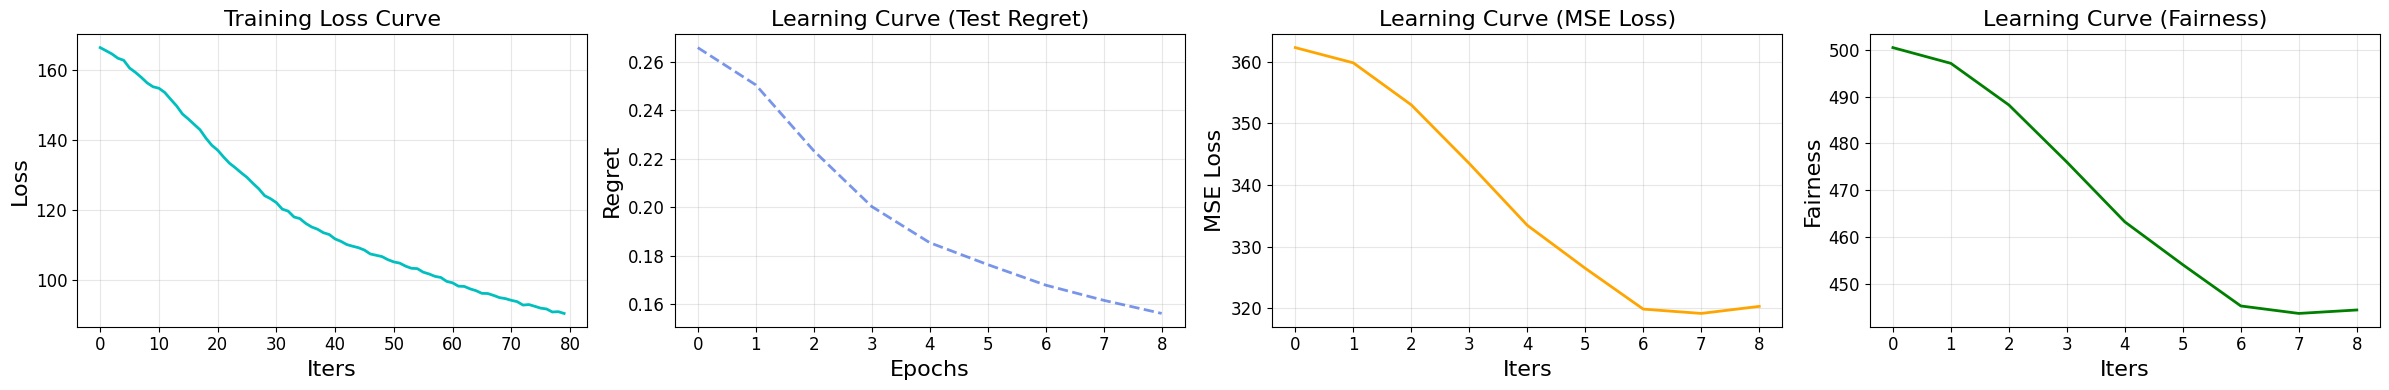

In [19]:
# alpha = 2
hyperparams = {
    "alpha":2,
    "Q": 2500,
    "lambda_fair": 0,
    "fairness_type": "mad",   
    "group": False,            # Set to True for group fairness, False for individual
    "grad_method": "finite-diff",
    "num_epochs": 80,        
    "batch_size": len(b_train),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "init_lr":1e-3
}

final_model, logs = train_model_regret(
    X_train=feats_train, y_train=b_train, race_train=race_train, cost_train=cost_train, gainF_train=gainF_train,
    X_test=feats_test, y_test=b_test, race_test=race_test, cost_test=cost_test, gainF_test=gainF_test,
    model_class=FairRiskPredictor,
    input_dim=feats_train.shape[1],
    **hyperparams
)


# Visualise the averaged learning curves
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])

Epoch 001/80 | Train-Loss 168.4734 | Test-MSE 362.2760 | Regret 0.2657 | Fair-Val 500.5617
Epoch 010/80 | Train-Loss 110.4076 | Test-MSE 329.7379 | Regret 0.1804 | Fair-Val 459.7502
Epoch 020/80 | Train-Loss 74.4189 | Test-MSE 310.1448 | Regret 0.1289 | Fair-Val 434.0812
Epoch 030/80 | Train-Loss 49.4429 | Test-MSE 294.7665 | Regret 0.0907 | Fair-Val 411.3924
Epoch 040/80 | Train-Loss 37.4320 | Test-MSE 276.8046 | Regret 0.0723 | Fair-Val 384.7065
Epoch 050/80 | Train-Loss 32.4308 | Test-MSE 261.2437 | Regret 0.0654 | Fair-Val 362.9905
Epoch 060/80 | Train-Loss 32.9855 | Test-MSE 256.6678 | Regret 0.0658 | Fair-Val 356.7719
Epoch 070/80 | Train-Loss 35.2122 | Test-MSE 254.9055 | Regret 0.0696 | Fair-Val 354.7105
Epoch 080/80 | Train-Loss 37.7496 | Test-MSE 255.5815 | Regret 0.0731 | Fair-Val 355.8584
Training finished in 4.31s.


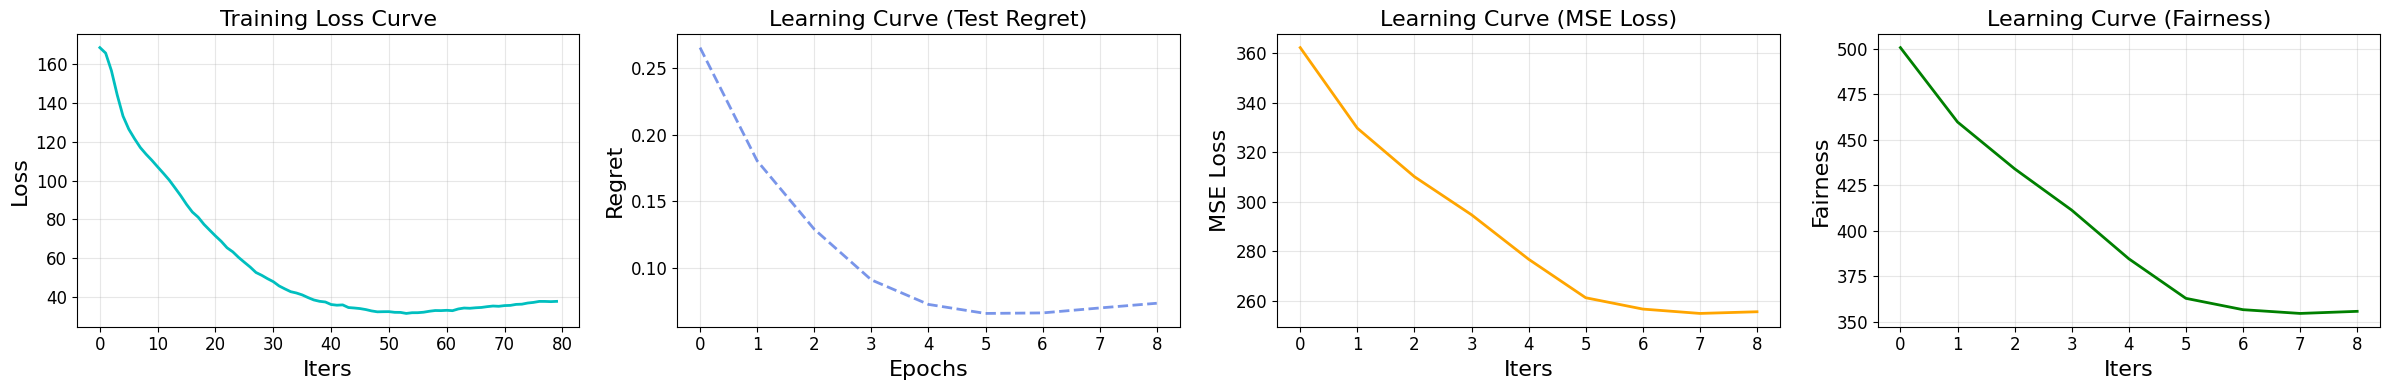

In [17]:
# alpha = 2
hyperparams = {
    "alpha":2,
    "Q": 2500,
    "lambda_fair": 0,
    "fairness_type": "mad",   
    "group": False,            # Set to True for group fairness, False for individual
    "grad_method": "closed-form",
    "num_epochs": 80,        
    "batch_size": len(b_train),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "init_lr":5e-3,
    "scheduler_patience":10
}

final_model, logs = train_model_regret(
    X_train=feats_train, y_train=b_train, race_train=race_train, cost_train=cost_train, gainF_train=gainF_train,
    X_test=feats_test, y_test=b_test, race_test=race_test, cost_test=cost_test, gainF_test=gainF_test,
    model_class=FairRiskPredictor,
    input_dim=feats_train.shape[1],
    **hyperparams
)


# Visualise the averaged learning curves
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])

In [14]:
# ---------------------------------------------------------------------
# 1.  MULTI-TRIAL REGRET TRAINING WITH FULL LOGGING
# ---------------------------------------------------------------------
def train_many_trials_regret(n_trials=3, base_seed=2025, **train_args):
    """
    Run `train_model_regret` for `n_trials` different seeds.
    Returns a FLAT dict whose keys are:
        regret, regret_std, mse, mse_std, fairness, fairness_std, …,
        G0_mse, G0_mse_std, G0_decision_obj, G0_decision_obj_std, …
    """
    # -------------------- run all trials -----------------------------
    per_trial_metrics = defaultdict(list)      # collects trial-level scalars

    final_model = None
    for t in range(n_trials):
        seed = base_seed + t
        torch.manual_seed(seed)

        final_model, logs = train_model_regret(**train_args)   # one full run

        # ---- overall scalars ---------------------------------------
        per_trial_metrics['regret'       ].append(logs['regret_log']  [-1])
        per_trial_metrics['mse'          ].append(logs['mse_log']     [-1])
        per_trial_metrics['fairness'     ].append(logs['fairness_log'][-1])
        per_trial_metrics['training_time'].append(logs['training_time'])

        # ---- per-group metrics (final epoch) -----------------------
        for g_id, g_log in logs['per_group_mse'].items():
            if g_log:                      # just in case
                per_trial_metrics[f'G{int(g_id)}_mse'          ].append(g_log[-1])
        for g_id, g_log in logs['per_group_decision_objective'].items():
            if g_log:
                per_trial_metrics[f'G{int(g_id)}_decision_obj' ].append(g_log[-1])


    # -------------------- aggregate over trials ----------------------
    avg_results = {}
    print("\n" + "="*60)
    print("      AVERAGED RESULTS ACROSS ALL TRIALS")
    print("="*60)

    for key, values in per_trial_metrics.items():
        μ, sigma = np.mean(values), np.std(values)
        avg_results[key]      = μ
        avg_results[f'{key}_std'] = sigma
        print(f"[{key.upper():>20s}]  μ = {μ:.4f} | σ = {sigma:.4f}")

    return avg_results, final_model


# Run Training

In [15]:
# --- Hyperparameter Grid Definition ---
alphas = [0.5,2.0]
group_settings = [True, False]
grad_methods = ['closed-form', 'finite-diff']  # New parameter

# ---------------------------------------------------------------------
# 2.  GRID-SEARCH HARNESS  (only the inner loop changed)
# ---------------------------------------------------------------------
results_list = []

for group in group_settings:
    fairness_types = ['atkinson']
    for grad_method in grad_methods:
        for fairness in fairness_types:
            if fairness == 'mad':
                fairness_lambdas = [0, 0.01, 1]
            elif fairness == 'atkinson':
                fairness_lambdas = [0, 1, 10]
            else:
                fairness_lambdas = [0]
            for lam in fairness_lambdas:
                for alpha in alphas:

                    run_params = {
                        'Group': group,
                        'Grad Method': grad_method,
                        'Alpha': alpha,
                        'Lambda': lam,
                        'Fairness': fairness
                    }
                    print("\n" + "-"*70)
                    print(f"RUNNING EXPERIMENT: {run_params}")
                    print("-"*70)

                    train_args = dict(
                        X_train=feats_train, y_train=b_train, race_train=race_train,
                        cost_train=cost_train, gainF_train=gainF_train,
                        X_test=feats_test,  y_test=b_test,  race_test=race_test,
                        cost_test=cost_test, gainF_test=gainF_test,
                        model_class=FairRiskPredictor,
                        input_dim=feats_train.shape[1],
                        alpha=alpha, Q=Q,
                        lambda_fair=lam, fairness_type=fairness,
                        group=group, grad_method=grad_method,
                        num_epochs=50
                    )

                    avg_results, final_model = train_many_trials_regret(
                        n_trials=1, **train_args) #type: ignore[call-arg]

                    # ---------------- build DataFrame row ------------
                    row = run_params.copy()
                    row.update(avg_results)          # every metric goes in
                    results_list.append(row)
                    # ---------------- save the final model ------------
                    # model_name = f"predmodel_{fairness}_{lam}_{grad_method}_{group}_{alpha}_NN.pth"
                    # model_path = f"E:/myREPO/Fairness-Decision-Focused-Loss/Organized-FDFL/src/models/FDFL/{model_name}"
                    # torch.save(final_model.state_dict(), model_path) # type: ignore[arg-type]

# ---------------- DataFrame & LaTeX dump -----------------------------
results_df = pd.DataFrame(results_list)

# Put the hyper-parameters first; everything else follows automatically
hp_cols = ['Group', 'Grad Method', 'Alpha', 'Lambda', 'Fairness']
other_cols = sorted([c for c in results_df.columns if c not in hp_cols])
results_df = results_df[hp_cols + other_cols]

latex_table = results_df.to_latex(
    index=False,
    caption="Averaged Experimental Results Across Different Parameters.",
    label="tab:avg_exp_results_expanded",
    float_format="%.4f"
)

print("\n" + "="*90)
print("                           GRID SEARCH COMPLETE")
print("="*90)
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.width', 1200):
    print(results_df)

print("\n--- LaTeX Table Output ---")
print(latex_table)

# Run NN first, lr = 1e-3
# results_df.to_csv("closed-form-res-NN-temp.csv", index=False)


----------------------------------------------------------------------
RUNNING EXPERIMENT: {'Group': True, 'Grad Method': 'closed-form', 'Alpha': 0.5, 'Lambda': 0, 'Fairness': 'atkinson'}
----------------------------------------------------------------------
Epoch 001/50 | Train-Loss 25.0118 | Test-MSE 359.6337 | Regret 0.0689 | Fair-Val 0.0049
Epoch 010/50 | Train-Loss 15.1467 | Test-MSE 293.0108 | Regret 0.0483 | Fair-Val 0.0025
Epoch 020/50 | Train-Loss 7.4435 | Test-MSE 255.4644 | Regret 0.0270 | Fair-Val 0.0025
Epoch 030/50 | Train-Loss 4.5165 | Test-MSE 207.8653 | Regret 0.0195 | Fair-Val 0.0020
Epoch 040/50 | Train-Loss 4.1921 | Test-MSE 187.5378 | Regret 0.0187 | Fair-Val 0.0014
Epoch 050/50 | Train-Loss 4.5696 | Test-MSE 192.0479 | Regret 0.0207 | Fair-Val 0.0012
Training finished in 297.51s.

      AVERAGED RESULTS ACROSS ALL TRIALS
[              REGRET]  μ = 0.0207 | σ = 0.0000
[                 MSE]  μ = 192.0479 | σ = 0.0000
[            FAIRNESS]  μ = 0.0012 | σ = 0.000

# Results

In [16]:
raise ValueError

ValueError: 

In [ ]:
# Run Linear Reg with lr = 1e-3

: 

: 

: 

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x)

: 

: 

: 

In [ ]:
# --- Hyperparameter Grid Definition ---
alphas = [0.5, 0.8, 1.5, 2]
group_settings = [True, False]
grad_methods = ['closed-form', 'finite-diff']  # New parameter

# ---------------------------------------------------------------------
# 2.  GRID-SEARCH HARNESS  (only the inner loop changed)
# ---------------------------------------------------------------------
results_list = []
final_model_cf = None
final_model_fd = None

for group in group_settings:
    fairness_types = ['mad', 'atkinson']
    for grad_method in grad_methods:
        for fairness in fairness_types:
            if fairness == 'mad':
                fairness_lambdas = [0, 1, 0.01]
            elif fairness == 'atkinson':
                fairness_lambdas = [0, 1, 10]
            else:
                fairness_lambdas = [0]
            for lam in fairness_lambdas:
                if lam == 0 and fairness != fairness_types[0]:
                    continue  # skip unattainable combos
                for alpha in alphas:

                    run_params = {
                        'Group': group,
                        'Grad Method': grad_method,
                        'Alpha': alpha,
                        'Lambda': lam,
                        'Fairness': fairness
                    }
                    print("\n" + "-"*70)
                    print(f"RUNNING EXPERIMENT: {run_params}")
                    print("-"*70)

                    train_args = dict(
                        X_train=feats_train, y_train=b_train, race_train=race_train,
                        cost_train=cost_train, gainF_train=gainF_train,
                        X_test=feats_test,  y_test=b_test,  race_test=race_test,
                        cost_test=cost_test, gainF_test=gainF_test,
                        model_class=LinearRegressionModel,
                        input_dim=feats_train.shape[1],
                        alpha=alpha, Q=Q,
                        lambda_fair=lam, fairness_type=fairness,
                        group=group, grad_method=grad_method,
                        num_epochs=50, lr=0.001
                    )

                    avg_results, final_model = train_many_trials_regret(
                        n_trials=2, **train_args) # type: ignore[call-arg]
                    

                    # ---------------- build DataFrame row ------------
                    row = run_params.copy()
                    row.update(avg_results)          # every metric goes in
                    results_list.append(row)
                    # ---------------- save the final model ------------
                    model_name = f"predmodel_{fairness}_{lam}_{grad_method}_{group}_{alpha}_LR.pth"
                    model_path = f"E:/myREPO/Fairness-Decision-Focused-Loss/Organized-FDFL/src/models/FDFL/{model_name}"
                    torch.save(final_model.state_dict(), model_path) # type: ignore[arg-type]

# ---------------- DataFrame & LaTeX dump -----------------------------
results_df = pd.DataFrame(results_list)

# Put the hyper-parameters first; everything else follows automatically
hp_cols = ['Group', 'Grad Method', 'Alpha', 'Lambda', 'Fairness']
other_cols = sorted([c for c in results_df.columns if c not in hp_cols])
results_df = results_df[hp_cols + other_cols]

latex_table = results_df.to_latex(
    index=False,
    caption="Averaged Experimental Results Across Different Parameters.",
    label="tab:avg_exp_results_expanded",
    float_format="%.4f"
)

print("\n" + "="*90)
print("                           GRID SEARCH COMPLETE")
print("="*90)
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.width', 1200):
    print(results_df)

print("\n--- LaTeX Table Output ---")
print(latex_table)
results_df.to_csv("closed-form-res-LR.csv", index=False)




----------------------------------------------------------------------
RUNNING EXPERIMENT: {'Group': True, 'Grad Method': 'closed-form', 'Alpha': 0.5, 'Lambda': 0, 'Fairness': 'mad'}
----------------------------------------------------------------------
Epoch 001/50 | Train-Loss 28.6403 | Test-MSE 360.5598 | Regret 0.0630 | Fair-Val 84.4475
Epoch 010/50 | Train-Loss 27.7569 | Test-MSE 358.7179 | Regret 0.0617 | Fair-Val 83.2841
Epoch 020/50 | Train-Loss 26.6246 | Test-MSE 356.1054 | Regret 0.0598 | Fair-Val 81.7882
Epoch 030/50 | Train-Loss 25.6684 | Test-MSE 353.4138 | Regret 0.0582 | Fair-Val 80.3669
Epoch 040/50 | Train-Loss 24.9282 | Test-MSE 350.8079 | Regret 0.0569 | Fair-Val 79.1400
Epoch 050/50 | Train-Loss 24.3867 | Test-MSE 348.5539 | Regret 0.0559 | Fair-Val 78.0377
Training finished in 258.01s.
Epoch 001/50 | Train-Loss 28.8216 | Test-MSE 360.7564 | Regret 0.0629 | Fair-Val 85.1091
Epoch 010/50 | Train-Loss 27.9582 | Test-MSE 359.0159 | Regret 0.0611 | Fair-Val 84.2789
Epo

: 

: 

: 

: 

: 

: 